# Markov Decision Process (MDP)

### Ransalu Senanayake

In [42]:
import copy
import timeit
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline
from ipywidgets import interactive
import ipywidgets as widgets

Create the following grid world.

**States:** A 10x10 grid

**Actions:** Up, Down, Left, Right

**Tranistion probabilities:**
* 0.7 in the direction of action
* 0.1 in the three other directions
* The robot bounces back to the same state near edges

**Rewards:**
* (7,8) has a reward +10
* (2,7) has a reward +3
* (4,3) has a reward -5
* (7,3) has a reward -10
* No reward in other states

This example is based on Decision Making Under Uncertainty by M.J. Kochenderfer.

In [43]:
#Let's define MDP paras
def createGrid10World():
    def xy2s(y, x):
        x = max(x, 0)
        y = max(y, 0)
        x = min(x, 9)
        y = min(y, 9)
        out = np.ravel_multi_index(np.array([x,y]), (10,10))
        return out

    def s2xy(s):
        x, y = np.unravel_index(s, (10,10))
        return y, x

    def gridPlot(ax, im, title='', cmap='Blues'):
        pl.imshow(im, interpolation='none', cmap=cmap, origin='lower')
        pl.colorbar()
        ax.set_xticks(np.arange(0, 10, 1));
        ax.set_yticks(np.arange(0, 10, 1));
        ax.set_xticklabels(np.arange(0, 10, 1));
        ax.set_yticklabels(np.arange(0, 10, 1));
        ax.set_xticks(np.arange(-.5, 10, 1), minor=True);
        ax.set_yticks(np.arange(-.5, 10, 1), minor=True);
        ax.grid(which='minor', color='w', linestyle='-', linewidth=1)
        pl.title(title);
        return

    A = ['left', 'right', 'up', 'down']
    S = np.arange(100)
    T = np.zeros((len(S), len(A), len(S)))
    R = np.zeros((len(S), len(A)))
    for s in S:
        x, y = s2xy(s)
        if x == 2 and y == 7:
            R[s, :] = 3
        elif x == 7 and y == 8:
            R[s, :] = 10
        else:
            if x == 7 and y == 3:
                R[s, :] = -10
            elif x == 4 and y == 3:
                R[s, :] = -5
            elif x == 0:
                if y == 0 or y == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 0] = -0.7
            elif x == 9:
                if y == 0 or y == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 1] = -0.7
            elif y == 0:
                if x == 0 or x == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 3] = -0.7
            elif y == 9:
                if x == 0 or x == 9:
                    R[s, :] = -0.2
                else:
                    R[s, :] = -0.1
                R[s, 2] = -0.7

            for a in A:
                if a == 'left':
                    T[s, 0, xy2s(x - 1, y)] += 0.7
                    T[s, 0, xy2s(x + 1, y)] += 0.1
                    T[s, 0, xy2s(x, y - 1)] += 0.1
                    T[s, 0, xy2s(x, y + 1)] += 0.1
                elif a == 'right':
                    T[s, 1, xy2s(x + 1, y)] += 0.7
                    T[s, 1, xy2s(x - 1, y)] += 0.1
                    T[s, 1, xy2s(x, y - 1)] += 0.1
                    T[s, 1, xy2s(x, y + 1)] += 0.1
                elif a == 'up':
                    T[s, 2, xy2s(x, y + 1)] += 0.7
                    T[s, 2, xy2s(x, y - 1)] += 0.1
                    T[s, 2, xy2s(x - 1, y)] += 0.1
                    T[s, 2, xy2s(x + 1, y)] += 0.1
                elif a == 'down':
                    T[s, 3, xy2s(x, y - 1)] += 0.7
                    T[s, 3, xy2s(x, y + 1)] += 0.1
                    T[s, 3, xy2s(x - 1, y)] += 0.1
                    T[s, 3, xy2s(x + 1, y)] += 0.1

    for a, c_x, c_y in [(0,0,0), (0,0,9),(1,9,0),(1,9,9),(2,0,9),(2,9,9),(3,0,0),(3,9,0)]:
        R[xy2s(c_x,c_y),a] = -0.8

    discount = 0.9

    nextStates = {}
    for si in range(len(S)):
        for ai in range(len(A)):
            nextStates[(si,ai)] = np.where((T[si, ai, :] != 0) == True)[0]

    return {'S':S, 'A':A, 'T':T, 'R':R, 'discount':discount, 'nextStates':nextStates, 'gridPlot':gridPlot, 'xy2s':xy2s, 's2xy':s2xy}

In [44]:
class MDP():
    def __init__(self):
        pass

    def inbuilt_init(self, mdp_dict):
        self.S = mdp_dict['S']
        self.A = mdp_dict['A']
        self.T = mdp_dict['T']
        self.R = mdp_dict['R']
        self.discount = mdp_dict['discount']
        self.nextStates = mdp_dict['nextStates']
        self.gridPlot = mdp_dict['gridPlot']
        self.xy2s = mdp_dict['xy2s']
        self.s2xy = mdp_dict['s2xy']

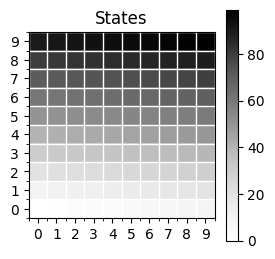

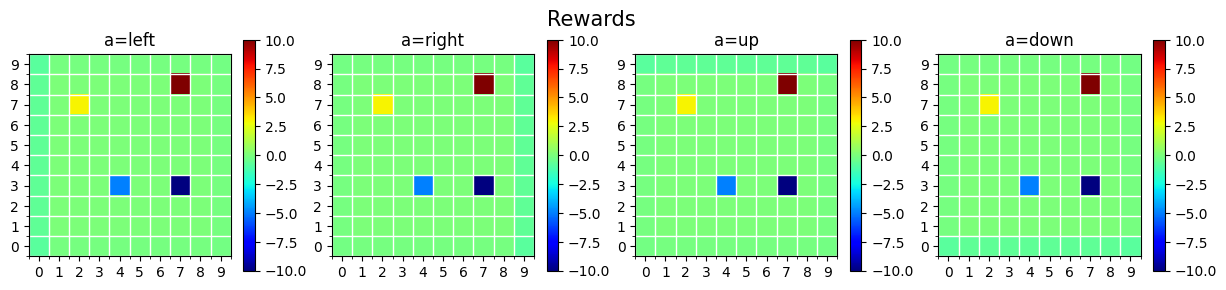

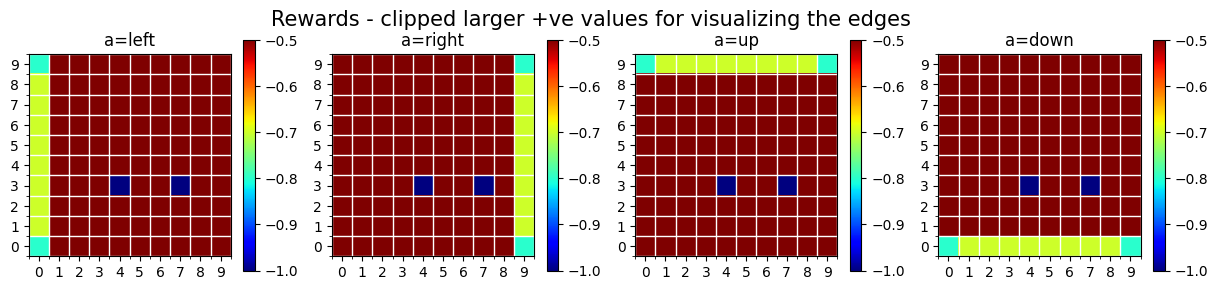

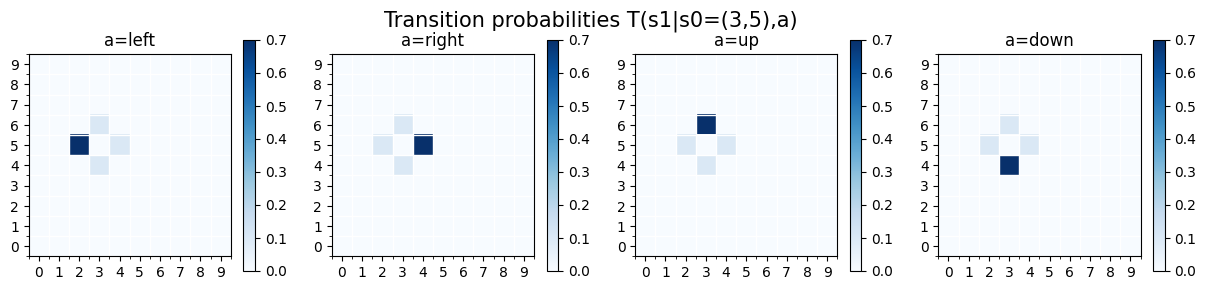

In [45]:
#Define the MDP
mdp = MDP()
mdp.inbuilt_init(mdp_dict=createGrid10World())

#Plot states
pl.figure(figsize=(3,3))
mdp.gridPlot(ax=pl.gca(), im=mdp.S.reshape((10,10)), title='States', cmap='Greys')

#Plot rewards
pl.figure(figsize=(15,3))
pl.suptitle('Rewards', fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    mdp.gridPlot(ax=pl.gca(), im=mdp.R[:,a].reshape((10,10)), title='a='+mdp.A[a], cmap='jet')
pl.show()

#Plot rewards
pl.figure(figsize=(15,3))
pl.suptitle('Rewards - clipped larger +ve values for visualizing the edges', fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    mdp.gridPlot(ax=pl.gca(), im=np.clip(mdp.R[:,a].reshape((10,10)), -1, -0.5), title='a='+mdp.A[a], cmap='jet')
pl.show()

#Plot rewards
s0_x, s0_y = 3, 5
s0 = mdp.xy2s(s0_x, s0_y)
pl.figure(figsize=(15,3))
pl.suptitle('Transition probabilities T(s1|s0=({},{}),a)'.format(s0_x, s0_y), fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    mdp.gridPlot(ax=pl.gca(), im=mdp.T[s0,a,:].reshape((10,10)), title='a='+mdp.A[a], cmap='Blues')
pl.show()

In [46]:
#An interactive plot of transition probabilities
def f(s0_x, s0_y, action):
    a = mdp.A.index(action)
    s0 = mdp.xy2s(int(s0_x), int(s0_y))
    pl.figure(figsize=(6,6))
    title = 'Transition probabilities T(s1|s0=({},{}),a={})'.format(int(s0_x),int(s0_y),action)
    mdp.gridPlot(ax=pl.gca(), im=mdp.T[s0,a,:].reshape((10,10)), title=title, cmap='Blues')
    pl.show()

interactive_plot = interactive(f, s0_x='4', s0_y='5', action=widgets.ToggleButtons(options=['left', 'right', 'up', 'down']))
interactive_plot

interactive(children=(Text(value='4', description='s0_x'), Text(value='5', description='s0_y'), ToggleButtons(…

### 1. Policy evaluation

Computing the utility, U.

$U^\pi_k(s) = R(s, \pi(s)) + \gamma \sum_{s'} T(s' \mid s, \pi(s))U^\pi_{k-1}(s')$

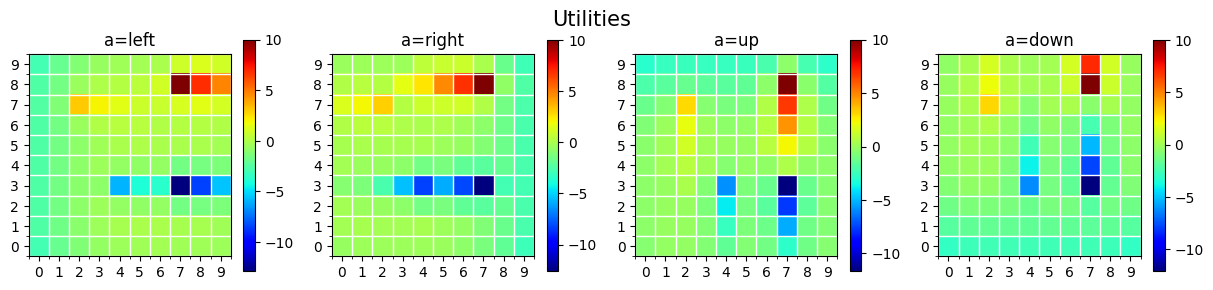

In [47]:
def iterativePolicyEvaluation(mdp, policy, numIterations=10):
    U = np.zeros(len(mdp.S))
    U_old = copy.copy(U)
    for t in range(numIterations):
      # IT21109126: Code completed
      for s in mdp.S:
        if policy == 0:
          a = 0
        elif policy == 1:
          a = 1
        elif policy == 2:
          a = 2
        elif policy == 3:
          a = 3
        next_states = mdp.nextStates[(s, a)]
        U[s] = mdp.R[s, a] + mdp.discount * np.sum(mdp.T[s, a, next_states] * U_old[next_states])
      U_old = copy.copy(U)
    return U

numIterations = 5
pl.figure(figsize=(15,3))
pl.suptitle('Utilities', fontsize=15)
for a in range(4):
    pl.subplot(1,4,a+1)
    U = iterativePolicyEvaluation(mdp=mdp, policy=a, numIterations=numIterations)
    mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='a='+mdp.A[a], cmap='jet')
pl.show()
#print(np.round(U.reshape(10,10),3))

In [48]:
def f(action, numIter=1):
    U = iterativePolicyEvaluation(mdp, policy=mdp.A.index(action), numIterations=numIter)
    pl.figure(figsize=(3,3))
    mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='Utility', cmap='jet')
    pl.show()

interactive_plot = interactive(f, action=widgets.ToggleButtons(options=['left', 'right', 'up', 'down']),
                               numIter=widgets.IntSlider(min=0, max=20, step=1, value=0))
interactive_plot

interactive(children=(ToggleButtons(description='action', options=('left', 'right', 'up', 'down'), value='left…

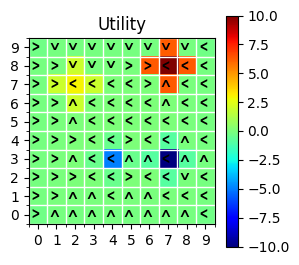

In [49]:
#Value iteration
def valueIteration(mdp, numIterations=1):
    U = np.zeros(len(mdp.S))
    U_old = copy.copy(U)
    for t in range(numIterations):
      # IT21109126: Code completed
      for s in mdp.S:
        max_utility = -np.inf
        for a in range(len(mdp.A)):
          next_states = mdp.nextStates[(s, a)]
          utility = mdp.R[s, a] + mdp.discount * np.sum(mdp.T[s, a, next_states] * U_old[next_states])
          if utility > max_utility:
            max_utility = utility
        U[s] = max_utility
      U_old = copy.copy(U)
    return U

def policyExtration(mdp, U):
  policy = np.zeros(len(mdp.S))
  # IT21109126: Code completed
  for s in mdp.S:
    max_utility = -np.inf
    best_action = 0
    for a in range(len(mdp.A)):
      next_states = mdp.nextStates[(s, a)]
      utility = mdp.R[s, a] + mdp.discount * np.sum(mdp.T[s, a, next_states] * U[next_states])
      if utility > max_utility:
        max_utility = utility
        best_action = a
    policy[s] = best_action
  return policy

U = valueIteration(mdp, numIterations=2)
policy = policyExtration(mdp, U=U)
pl.figure(figsize=(3,3))
mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='Utility', cmap='jet')
for s in range(100):
    x, y = mdp.s2xy(s)
    if policy[s] == 0:
        m='\u02C2'
    elif policy[s] == 1:
        m='\u02C3'
    elif policy[s] == 2:
        m='\u02C4'
    elif policy[s] == 3:
        m='\u02C5'
    pl.text(x-0.5,y-1,m,color='k',size=20)
pl.show()

In [50]:
def f(numIter=1):
    start_time = timeit.default_timer()
    U = valueIteration(mdp, numIterations=numIter)
    policy = policyExtration(mdp, U=U)
    elapsed = timeit.default_timer() - start_time
    print('time=', np.round(elapsed*1000,2))
    pl.figure(figsize=(3,3))
    mdp.gridPlot(ax=pl.gca(), im=U.reshape(10,10), title='Utility', cmap='jet')
    for s in range(100):
        x, y = mdp.s2xy(s)
        if policy[s] == 0:
            m='\u02C2'
        elif policy[s] == 1:
            m='\u02C3'
        elif policy[s] == 2:
            m='\u02C4'
        elif policy[s] == 3:
            m='\u02C5'
        pl.text(x-0.5,y-1,m,color='k',size=20)
    pl.show()

interactive_plot = interactive(f, numIter=widgets.IntSlider(min=0, max=20, step=1, value=0))
interactive_plot

interactive(children=(IntSlider(value=0, description='numIter', max=20), Output()), _dom_classes=('widget-inte…

### 2. Policy iteration

Policy evaluation can be used in policy iteration:
1. Given the current policy, compute U
2. Using U, compute a new policy

In [51]:
def policyIteration(mdp, numIterations=1):
  U_pi_k = np.zeros(len(mdp.S)) #initial values
  pi_k = np.random.randint(low=0,high=4,size=len(mdp.S),dtype=int) #initial policy
  pi_kp1 = copy.copy(pi_k)
  for t in range(numIterations):
    #Policy evaluation: compute U_pi_k
    # IT21109126: Code completed
    U_pi_k = iterativePolicyEvaluation(mdp, pi_k, numIterations=20)
    #Policy improvement
    # IT21109126: Code completed
    for s in mdp.S:
      max_utility = -np.inf
      best_action = 0
      for a in range(len(mdp.A)):
        next_states = mdp.nextStates[(s, a)]
        utility = mdp.R[s, a] + mdp.discount * np.sum(mdp.T[s, a, next_states] * U_pi_k[next_states])
        if utility > max_utility:
          max_utility = utility
          best_action = a
      pi_kp1[s] = best_action
    pi_k = copy.copy(pi_kp1)
  return U_pi_k, pi_kp1

# U_pi_k, pi_kp1 = policyIteration(mdp, numIterations=2)

In [52]:
def f(numIter=1):
    start_time = timeit.default_timer()
    # code you want to evaluate
    value, policy = policyIteration(mdp, numIterations=numIter)
    elapsed = timeit.default_timer() - start_time
    print('time=', np.round(elapsed*1000,2))
    pl.figure(figsize=(3,3))
    mdp.gridPlot(ax=pl.gca(), im=value.reshape(10,10), title='Utility', cmap='jet')
    for s in range(100):
        x, y = mdp.s2xy(s)
        if policy[s] == 0:
            m='\u02C2'
        elif policy[s] == 1:
            m='\u02C3'
        elif policy[s] == 2:
            m='\u02C4'
        elif policy[s] == 3:
            m='\u02C5'
        pl.text(x-0.5,y-1,m,color='k',size=20)
    pl.show()

interactive_plot = interactive(f, numIter=widgets.IntSlider(min=0, max=20, step=1, value=0))
interactive_plot

interactive(children=(IntSlider(value=0, description='numIter', max=20), Output()), _dom_classes=('widget-inte…

# IT21109126: Model-Free Approach (Q-Learning)

In [53]:
import random
import time

In [54]:
def qLearning(mdp, alpha=0.1, gamma=0.9, epsilon=0.1, numEpisodes=1000, maxSteps=100):
    Q = np.zeros((len(mdp.S), len(mdp.A)))

    for episode in range(numEpisodes):
        s0 = random.choice(range(len(mdp.S)))  # Start at a random state
        done = False
        step_count = 0

        while not done and step_count < maxSteps:
            if random.uniform(0, 1) < epsilon:
                action = random.choice(range(len(mdp.A)))  # Explore
            else:
                action = np.argmax(Q[s0])  # Exploit (best action)

            # Get transition probabilities for state s0 and action
            transition_probs = mdp.T[s0, action]

            # Normalize transition probabilities to sum to 1
            # Added check to handle cases where the sum is zero
            if np.sum(transition_probs) > 0:
                transition_probs /= np.sum(transition_probs)
            else:
                # Handle the case where there are no possible transitions
                # For example, set transition probabilities to a uniform distribution
                transition_probs = np.ones_like(transition_probs) / len(transition_probs)

            # Choose next state based on transition probabilities
            s1 = np.random.choice(range(len(mdp.S)), p=transition_probs)
            reward = mdp.R[s0, action]

            # Update Q-value
            Q[s0, action] = Q[s0, action] + alpha * (reward + gamma * np.max(Q[s1]) - Q[s0, action])

            s0 = s1  # Move to the next state
            step_count += 1

            done = False  # (or set up a proper terminal condition)

    return Q, time.time() # Added time.time() to return the time

In [55]:
def check_terminal_condition(s0):
  # Assume terminal states are where large positive or negative rewards are given
  terminal_states = [(7,8), (2,7), (4,3), (7,3)]
  s0_coords = mdp.s2xy(s0)  # Convert state index to coordinates
  return s0_coords in terminal_states

# IT21109126: Time Comparison

In [56]:
#Time Comparison

# Time Value Iteration
value_start_time = time.time()
U = valueIteration(mdp, numIterations=100)  # Run Value Iteration for 100 iterations
value_end_time = time.time()

# Extract Policy
policy = policyExtration(mdp, U=U)

# Time taken by Value Iteration
value_iteration_time = value_end_time - value_start_time
print(f"Value Iteration Time: {value_iteration_time} seconds")

# Time Q-Learning
q_values, q_learning_time = qLearning(mdp, numEpisodes=1000, maxSteps=100)

# Time taken by Q-Learning
print(f"Q-Learning Time: {q_learning_time} seconds")

Value Iteration Time: 0.4214911460876465 seconds
Q-Learning Time: 1728063857.981193 seconds


# IT21109126: Deep Q-Learning (DQN) Approach

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim

In [58]:
class DQNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [59]:
def epsilon_greedy_action_selection(state, epsilon, q_network):
    if np.random.rand() < epsilon:  # Exploration
        return np.random.choice(action_space)
    else:  # Exploitation
        with torch.no_grad():
            q_values = q_network(torch.FloatTensor(state))
        return np.argmax(q_values.numpy())  # Exploitation

In [60]:
import gym

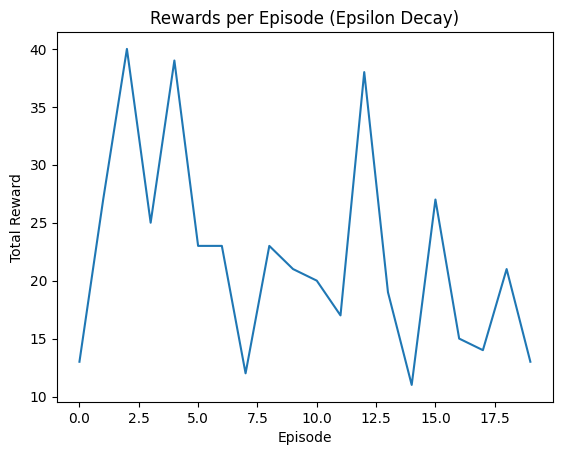

In [61]:
# Initialize the environment
env = gym.make('CartPole-v1')

# Hyperparameters
num_episodes = 20
epsilon = 1.0  # Initial epsilon value for exploration
epsilon_min = 0.9
epsilon_decay = 0.995
gamma = 0.99
learning_rate = 0.001

# Example: Placeholder Q-network function, replace with actual DQN
def q_network(state):
    # Placeholder for the actual neural network predicting Q-values
    return np.random.random(env.action_space.n)

# Epsilon-greedy action selection
def epsilon_greedy_action_selection(state, epsilon, q_network):
    if np.random.rand() < epsilon:
        return env.action_space.sample()  # Exploration: random action
    else:
        q_values = q_network(state)
        return np.argmax(q_values)  # Exploitation: action with max Q-value

# Placeholder for the DQN update, you will need to implement this
def update_dqn(state, action, reward, next_state, done):
    # This function should update the Q-network with new information
    pass

# Initialize rewards list
rewards_per_episode = []

# Training loop
for episode in range(num_episodes):
    state = env.reset()  # Reset environment at the start of each episode
    episode_reward = 0
    done = False
    while not done:
        # Select action using epsilon-greedy strategy
        action = epsilon_greedy_action_selection(state, epsilon, q_network)

        # Perform the action and get the next state, reward, and whether the episode is done
        next_state, reward, done, _ = env.step(action)

        # Accumulate episode reward
        episode_reward += reward

        # Update the DQN model
        update_dqn(state, action, reward, next_state, done)

        # Update current state to next state
        state = next_state

    # Record the total reward for this episode
    rewards_per_episode.append(episode_reward)

    # Decay epsilon after each episode to reduce exploration
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

# Plotting performance
pl.plot(rewards_per_episode)
pl.xlabel('Episode')
pl.ylabel('Total Reward')
pl.title(f'Rewards per Episode (Epsilon Decay)')
pl.show()